In [32]:
%matplotlib inline

In [33]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [34]:
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [35]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [36]:
train_features = train_features.astype('float32') / 255.
test_features = test_features.astype('float32') / 255.

In [37]:
train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [38]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
parameters = []

In [39]:
nm_epochs = 50
batch_size = 100
num_filters = np.arange(1, 76)
train_num_batches_per_epoch = num_train // batch_size
test_num_batches_per_epoch = num_test // batch_size

x = tf.placeholder('float', [None, img_rows, img_cols, img_channels])
y = tf.placeholder('float', [None, num_classes])
keep_prob = tf.placeholder(tf.float32)

In [40]:
num_filters

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75])

In [41]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

In [42]:
def maxpool2d(x):
    #                        size of window         movement of window
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [43]:
def neural_network_model(x, num_filter, keep_prob): 
    weights = {'W_conv1':tf.Variable(tf.truncated_normal([3,3,3,num_filter], stddev=0.1)),
               'W_conv2':tf.Variable(tf.truncated_normal([3,3,num_filter,num_filter], stddev=0.1)),                            
               'W_fc':tf.Variable(tf.truncated_normal([8*8*num_filter,512], stddev=0.1)),
               'out':tf.Variable(tf.truncated_normal([512, num_classes], stddev=0.1))}

    biases = {'b_conv1':tf.Variable(tf.constant(0.1, shape=[num_filter])),
               'b_conv2':tf.Variable(tf.constant(0.1, shape=[num_filter])),
               'b_fc':tf.Variable(tf.constant(0.1, shape=[512])),
               'out':tf.Variable(tf.constant(0.1, shape=[num_classes]))}

    conv1 = tf.nn.relu(conv2d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool2d(conv1)
    conv2 = tf.nn.relu(conv2d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool2d(conv2)
    
    fc = tf.reshape(conv2,[-1, 8*8*num_filter])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_prob)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [44]:
def next_batch(source, target, batch_size):

   # Shuffle data
   shuffle_indices = np.random.permutation(np.arange(len(target)))
   source = source[shuffle_indices]
   target = target[shuffle_indices]

   for batch_i in range(0, len(source)//batch_size):
      start_i = batch_i * batch_size
      source_batch = source[start_i:start_i + batch_size]
      target_batch = target[start_i:start_i + batch_size]

      yield np.array(source_batch), np.array(target_batch)

In [45]:
def train_neural_network(x):
    for num_filter in num_filters:
        prediction = neural_network_model(x, num_filter, keep_prob)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1)), tf.float32))
        optimizer = tf.train.AdamOptimizer().minimize(cost)

        config=tf.ConfigProto()
        config.gpu_options.allow_growth=True
        
        with tf.Session(config=config) as sess:
            sess.run(tf.global_variables_initializer())

            for epoch in range(nm_epochs):
                training_loss = 0.0
                training_acc = 0.0
                testing_loss = 0.0
                testing_acc = 0.0
                for epoch_x, epoch_y in next_batch(train_features, train_labels, batch_size):
                    _, c, a = sess.run([optimizer, cost, accuracy], feed_dict={x: epoch_x, y: epoch_y, keep_prob : 0.5})
                    training_loss += c / train_num_batches_per_epoch
                    training_acc += a / train_num_batches_per_epoch

                print('Epoch', epoch, 'completed out of',nm_epochs,'train_loss:',training_loss, 'train_accuracy:', training_acc)
                
            for epoch_x, epoch_y in next_batch(test_features, test_labels, batch_size):
                c, a = sess.run([cost, accuracy], feed_dict={x: epoch_x, y: epoch_y, keep_prob : 1.0})
                testing_loss += c / test_num_batches_per_epoch
                testing_acc += a / test_num_batches_per_epoch

            print('test_loss:',testing_loss, 'test_accuracy:', testing_acc)
                
            train_loss.append(training_loss)
            test_loss.append(testing_loss)
            train_acc.append(training_acc)
            test_acc.append(testing_acc)
            parameters.append(np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()]))
            print(parameters)

In [46]:
train_neural_network(x)

Epoch 0 completed out of 50 train_loss: 2.0947078857421872 train_accuracy: 0.23464000035077331
Epoch 1 completed out of 50 train_loss: 1.9180189008712747 train_accuracy: 0.31364000090956734
Epoch 2 completed out of 50 train_loss: 1.8565896494388565 train_accuracy: 0.3328800015151505
Epoch 3 completed out of 50 train_loss: 1.8163962552547466 train_accuracy: 0.34800000157952327
Epoch 4 completed out of 50 train_loss: 1.7883298530578622 train_accuracy: 0.357540000766516
Epoch 5 completed out of 50 train_loss: 1.7669202494621283 train_accuracy: 0.3686600007116795
Epoch 6 completed out of 50 train_loss: 1.7505497059822088 train_accuracy: 0.3742199997603894
Epoch 7 completed out of 50 train_loss: 1.7361799924373624 train_accuracy: 0.38155999946594255
Epoch 8 completed out of 50 train_loss: 1.72242373943329 train_accuracy: 0.3855999991595739
Epoch 9 completed out of 50 train_loss: 1.7052955286502847 train_accuracy: 0.39173999929428094
Epoch 10 completed out of 50 train_loss: 1.69618819308281 

Epoch 36 completed out of 50 train_loss: 1.2315923974513996 train_accuracy: 0.5671799986362457
Epoch 37 completed out of 50 train_loss: 1.2271269258260726 train_accuracy: 0.5697399978637693
Epoch 38 completed out of 50 train_loss: 1.220363366484643 train_accuracy: 0.5713999971747401
Epoch 39 completed out of 50 train_loss: 1.2167705684900278 train_accuracy: 0.5736399997472766
Epoch 40 completed out of 50 train_loss: 1.2137135959863674 train_accuracy: 0.5728399980068205
Epoch 41 completed out of 50 train_loss: 1.2067578450441352 train_accuracy: 0.5756399990320203
Epoch 42 completed out of 50 train_loss: 1.2065679112672807 train_accuracy: 0.5754599980711936
Epoch 43 completed out of 50 train_loss: 1.2008908042907713 train_accuracy: 0.5748599979281422
Epoch 44 completed out of 50 train_loss: 1.1928229888677593 train_accuracy: 0.5785399976372714
Epoch 45 completed out of 50 train_loss: 1.1917902859449379 train_accuracy: 0.5787199984788899
Epoch 46 completed out of 50 train_loss: 1.18669697

Epoch 21 completed out of 50 train_loss: 1.0447409681081785 train_accuracy: 0.6286400007605562
Epoch 22 completed out of 50 train_loss: 1.0352989114522944 train_accuracy: 0.6352200006842618
Epoch 23 completed out of 50 train_loss: 1.0179461034536357 train_accuracy: 0.640640000700951
Epoch 24 completed out of 50 train_loss: 1.0139237853288654 train_accuracy: 0.6425000000000006
Epoch 25 completed out of 50 train_loss: 1.0000202229022976 train_accuracy: 0.6466999999284754
Epoch 26 completed out of 50 train_loss: 0.9923962122201915 train_accuracy: 0.6507400021553046
Epoch 27 completed out of 50 train_loss: 0.978542609810829 train_accuracy: 0.6535800015926369
Epoch 28 completed out of 50 train_loss: 0.9720320595502858 train_accuracy: 0.6578200021982202
Epoch 29 completed out of 50 train_loss: 0.9626964385509484 train_accuracy: 0.661300002098084
Epoch 30 completed out of 50 train_loss: 0.950700580120087 train_accuracy: 0.6635800015926371
Epoch 31 completed out of 50 train_loss: 0.94194314038

Epoch 6 completed out of 50 train_loss: 1.1640471987724315 train_accuracy: 0.5890599979162214
Epoch 7 completed out of 50 train_loss: 1.1340782085657108 train_accuracy: 0.5988799981474878
Epoch 8 completed out of 50 train_loss: 1.1053536603450782 train_accuracy: 0.6097800005078319
Epoch 9 completed out of 50 train_loss: 1.0789557965993881 train_accuracy: 0.6203800009489061
Epoch 10 completed out of 50 train_loss: 1.0498793599605554 train_accuracy: 0.6294400020837793
Epoch 11 completed out of 50 train_loss: 1.028673790335655 train_accuracy: 0.6386399997472765
Epoch 12 completed out of 50 train_loss: 1.0021938062906266 train_accuracy: 0.6470600010156636
Epoch 13 completed out of 50 train_loss: 0.9844766393899931 train_accuracy: 0.6529800009727483
Epoch 14 completed out of 50 train_loss: 0.9641006927490234 train_accuracy: 0.6601800011396411
Epoch 15 completed out of 50 train_loss: 0.9379322768449787 train_accuracy: 0.6705800017118467
Epoch 16 completed out of 50 train_loss: 0.922286391377

Epoch 42 completed out of 50 train_loss: 0.5583588500022886 train_accuracy: 0.797579998016356
Epoch 43 completed out of 50 train_loss: 0.552822733938694 train_accuracy: 0.7982399990558611
Epoch 44 completed out of 50 train_loss: 0.5436562424302099 train_accuracy: 0.803759998083113
Epoch 45 completed out of 50 train_loss: 0.5314023868441583 train_accuracy: 0.8075199990272516
Epoch 46 completed out of 50 train_loss: 0.5254171394705772 train_accuracy: 0.8085399971008288
Epoch 47 completed out of 50 train_loss: 0.5209162723422052 train_accuracy: 0.8095799992084494
Epoch 48 completed out of 50 train_loss: 0.5049137961864472 train_accuracy: 0.8161399983167633
Epoch 49 completed out of 50 train_loss: 0.498763636648655 train_accuracy: 0.8186799986362447
test_loss: 1.2162925833463665 test_accuracy: 0.6494000005722046
[597556, 668828, 772942, 909916, 1079768, 1282516, 1518178]
Epoch 0 completed out of 50 train_loss: 1.7369934868812544 train_accuracy: 0.368679998144507
Epoch 1 completed out of 50

Epoch 26 completed out of 50 train_loss: 0.6043104975819589 train_accuracy: 0.7852199983596795
Epoch 27 completed out of 50 train_loss: 0.5877302579283714 train_accuracy: 0.7906199977397904
Epoch 28 completed out of 50 train_loss: 0.5795682304501545 train_accuracy: 0.7919599975347509
Epoch 29 completed out of 50 train_loss: 0.5617330635786062 train_accuracy: 0.7974999972581862
Epoch 30 completed out of 50 train_loss: 0.5522686632871626 train_accuracy: 0.8025599983930584
Epoch 31 completed out of 50 train_loss: 0.5317300207614897 train_accuracy: 0.8078199990987771
Epoch 32 completed out of 50 train_loss: 0.5215689539909364 train_accuracy: 0.8122999978065473
Epoch 33 completed out of 50 train_loss: 0.5086691365242006 train_accuracy: 0.8162599991559966
Epoch 34 completed out of 50 train_loss: 0.4964174116849894 train_accuracy: 0.8194599992036814
Epoch 35 completed out of 50 train_loss: 0.48417306661605847 train_accuracy: 0.8256599980592708
Epoch 36 completed out of 50 train_loss: 0.478626

Epoch 10 completed out of 50 train_loss: 0.8552619358301163 train_accuracy: 0.6978400015830991
Epoch 11 completed out of 50 train_loss: 0.8263111430406576 train_accuracy: 0.7101800013780587
Epoch 12 completed out of 50 train_loss: 0.7931354227066043 train_accuracy: 0.7204800016880025
Epoch 13 completed out of 50 train_loss: 0.7690321018695829 train_accuracy: 0.7309200004339214
Epoch 14 completed out of 50 train_loss: 0.7317822810411454 train_accuracy: 0.7417800000905984
Epoch 15 completed out of 50 train_loss: 0.706903470873832 train_accuracy: 0.7496399998664848
Epoch 16 completed out of 50 train_loss: 0.6763973299264909 train_accuracy: 0.7596799986362442
Epoch 17 completed out of 50 train_loss: 0.6575497496724134 train_accuracy: 0.7666799987554541
Epoch 18 completed out of 50 train_loss: 0.6340757332444189 train_accuracy: 0.7735999994277944
Epoch 19 completed out of 50 train_loss: 0.6101054196357729 train_accuracy: 0.7818399988412837
Epoch 20 completed out of 50 train_loss: 0.58862498

Epoch 45 completed out of 50 train_loss: 0.2724419548362493 train_accuracy: 0.902460000872612
Epoch 46 completed out of 50 train_loss: 0.27240314644575153 train_accuracy: 0.9002800002098101
Epoch 47 completed out of 50 train_loss: 0.2595563078522683 train_accuracy: 0.9051800012588501
Epoch 48 completed out of 50 train_loss: 0.26047049392759786 train_accuracy: 0.906240001559258
Epoch 49 completed out of 50 train_loss: 0.2553723984062674 train_accuracy: 0.907920003175736
test_loss: 1.29815962433815 test_accuracy: 0.6918000000715259
[597556, 668828, 772942, 909916, 1079768, 1282516, 1518178, 1786772, 2088316, 2422828, 2790326, 3190828]
Epoch 0 completed out of 50 train_loss: 1.70584892320633 train_accuracy: 0.38253999818861456
Epoch 1 completed out of 50 train_loss: 1.3487546217441553 train_accuracy: 0.516579996705055
Epoch 2 completed out of 50 train_loss: 1.2119457825422277 train_accuracy: 0.5719999977946283
Epoch 3 completed out of 50 train_loss: 1.1192172238826756 train_accuracy: 0.60

Epoch 28 completed out of 50 train_loss: 0.33673596578836457 train_accuracy: 0.8780400003194824
Epoch 29 completed out of 50 train_loss: 0.3236618047058581 train_accuracy: 0.8831799995899209
Epoch 30 completed out of 50 train_loss: 0.3169085585772989 train_accuracy: 0.8857199991941448
Epoch 31 completed out of 50 train_loss: 0.30667028057575274 train_accuracy: 0.8888400013446814
Epoch 32 completed out of 50 train_loss: 0.29642688675224793 train_accuracy: 0.8933400015830993
Epoch 33 completed out of 50 train_loss: 0.28796711733937275 train_accuracy: 0.8960200004577636
Epoch 34 completed out of 50 train_loss: 0.27681758196651957 train_accuracy: 0.8991800011396415
Epoch 35 completed out of 50 train_loss: 0.271912080094218 train_accuracy: 0.9013800021409996
Epoch 36 completed out of 50 train_loss: 0.26249296393990507 train_accuracy: 0.9058800029754642
Epoch 37 completed out of 50 train_loss: 0.253211604759097 train_accuracy: 0.9087000023126611
Epoch 38 completed out of 50 train_loss: 0.246

Epoch 11 completed out of 50 train_loss: 0.6538794215917593 train_accuracy: 0.7713399991989129
Epoch 12 completed out of 50 train_loss: 0.6182614998221403 train_accuracy: 0.7831199983358377
Epoch 13 completed out of 50 train_loss: 0.5883736997842793 train_accuracy: 0.7922799973487838
Epoch 14 completed out of 50 train_loss: 0.5586143588423732 train_accuracy: 0.8016199978590001
Epoch 15 completed out of 50 train_loss: 0.5287989743351937 train_accuracy: 0.8131399973630894
Epoch 16 completed out of 50 train_loss: 0.491245175868273 train_accuracy: 0.8256199978590003
Epoch 17 completed out of 50 train_loss: 0.46683456236124005 train_accuracy: 0.8334799968004224
Epoch 18 completed out of 50 train_loss: 0.4465154517889023 train_accuracy: 0.8406199983358364
Epoch 19 completed out of 50 train_loss: 0.4279643796980378 train_accuracy: 0.8470799986124029
Epoch 20 completed out of 50 train_loss: 0.4034801347851756 train_accuracy: 0.8554199993610365
Epoch 21 completed out of 50 train_loss: 0.3902141

Epoch 46 completed out of 50 train_loss: 0.18415700325369833 train_accuracy: 0.9350200022459038
Epoch 47 completed out of 50 train_loss: 0.18212665543705236 train_accuracy: 0.9352000025510789
Epoch 48 completed out of 50 train_loss: 0.17372221123427156 train_accuracy: 0.9382800016403215
Epoch 49 completed out of 50 train_loss: 0.17997635672241444 train_accuracy: 0.9369400002956413
test_loss: 1.5698392736911775 test_accuracy: 0.6917000037431718
[597556, 668828, 772942, 909916, 1079768, 1282516, 1518178, 1786772, 2088316, 2422828, 2790326, 3190828, 3624352, 4090916, 4590538, 5123236, 5689028]
Epoch 0 completed out of 50 train_loss: 1.6819709994792946 train_accuracy: 0.39645999818295186
Epoch 1 completed out of 50 train_loss: 1.3221712815761555 train_accuracy: 0.5270799957513806
Epoch 2 completed out of 50 train_loss: 1.1987206073999401 train_accuracy: 0.5732799980044371
Epoch 3 completed out of 50 train_loss: 1.103370267033577 train_accuracy: 0.6088999999761576
Epoch 4 completed out of 5

Epoch 28 completed out of 50 train_loss: 0.26171945394575596 train_accuracy: 0.9066200014352808
Epoch 29 completed out of 50 train_loss: 0.2559913003593681 train_accuracy: 0.9080000009536745
Epoch 30 completed out of 50 train_loss: 0.2488205986768008 train_accuracy: 0.910300001263619
Epoch 31 completed out of 50 train_loss: 0.23692058499157423 train_accuracy: 0.9157400019168856
Epoch 32 completed out of 50 train_loss: 0.23261436867713903 train_accuracy: 0.9163200007677074
Epoch 33 completed out of 50 train_loss: 0.21915088418126089 train_accuracy: 0.9201600019931785
Epoch 34 completed out of 50 train_loss: 0.21245484346151364 train_accuracy: 0.9248400018215182
Epoch 35 completed out of 50 train_loss: 0.21087410195916884 train_accuracy: 0.924180001854897
Epoch 36 completed out of 50 train_loss: 0.20172800226509585 train_accuracy: 0.9297000015974052
Epoch 37 completed out of 50 train_loss: 0.19933463284373265 train_accuracy: 0.9296600021123895
Epoch 38 completed out of 50 train_loss: 0.1

Epoch 10 completed out of 50 train_loss: 0.6499423897862431 train_accuracy: 0.7704799990653983
Epoch 11 completed out of 50 train_loss: 0.6156546837091447 train_accuracy: 0.7830599981546389
Epoch 12 completed out of 50 train_loss: 0.5690946358442311 train_accuracy: 0.798859998226164
Epoch 13 completed out of 50 train_loss: 0.5336344192028042 train_accuracy: 0.8097599967718113
Epoch 14 completed out of 50 train_loss: 0.5030480818748471 train_accuracy: 0.8214399980306606
Epoch 15 completed out of 50 train_loss: 0.4687366129755972 train_accuracy: 0.834119998455046
Epoch 16 completed out of 50 train_loss: 0.44554540258645997 train_accuracy: 0.8412199978828423
Epoch 17 completed out of 50 train_loss: 0.4078758350312712 train_accuracy: 0.8543199989795676
Epoch 18 completed out of 50 train_loss: 0.3939452993273737 train_accuracy: 0.8597599985599519
Epoch 19 completed out of 50 train_loss: 0.37117525991797434 train_accuracy: 0.8682799997329712
Epoch 20 completed out of 50 train_loss: 0.3464587

Epoch 44 completed out of 50 train_loss: 0.14338874720782036 train_accuracy: 0.9492600010633495
Epoch 45 completed out of 50 train_loss: 0.13896268088370547 train_accuracy: 0.9506400022506749
Epoch 46 completed out of 50 train_loss: 0.1370904349386692 train_accuracy: 0.951660001397136
Epoch 47 completed out of 50 train_loss: 0.14025894935801628 train_accuracy: 0.9512000014781992
Epoch 48 completed out of 50 train_loss: 0.13033117058128116 train_accuracy: 0.9538200021982224
Epoch 49 completed out of 50 train_loss: 0.12979433148354297 train_accuracy: 0.9540000042915369
test_loss: 1.461146823167801 test_accuracy: 0.7147000044584272
[597556, 668828, 772942, 909916, 1079768, 1282516, 1518178, 1786772, 2088316, 2422828, 2790326, 3190828, 3624352, 4090916, 4590538, 5123236, 5689028, 6287932, 6919966, 7585148, 8283496, 9015028]
Epoch 0 completed out of 50 train_loss: 1.7192735762596154 train_accuracy: 0.3819799989461899
Epoch 1 completed out of 50 train_loss: 1.3251594642400735 train_accuracy:

Epoch 25 completed out of 50 train_loss: 0.2376224955916407 train_accuracy: 0.9157800018787373
Epoch 26 completed out of 50 train_loss: 0.23213201117515553 train_accuracy: 0.9184800020456315
Epoch 27 completed out of 50 train_loss: 0.2130516607016324 train_accuracy: 0.9239200022220608
Epoch 28 completed out of 50 train_loss: 0.2017801787406206 train_accuracy: 0.9283400021791456
Epoch 29 completed out of 50 train_loss: 0.19271946772187948 train_accuracy: 0.9315400017499919
Epoch 30 completed out of 50 train_loss: 0.19167386388778673 train_accuracy: 0.9312400012016303
Epoch 31 completed out of 50 train_loss: 0.1826338849589229 train_accuracy: 0.935780002355577
Epoch 32 completed out of 50 train_loss: 0.17806970539689065 train_accuracy: 0.9383399991989151
Epoch 33 completed out of 50 train_loss: 0.1801193920522929 train_accuracy: 0.9350400016307833
Epoch 34 completed out of 50 train_loss: 0.1767986406013368 train_accuracy: 0.9384200025796895
Epoch 35 completed out of 50 train_loss: 0.1657

Epoch 6 completed out of 50 train_loss: 0.8012932404279711 train_accuracy: 0.7204600013494483
Epoch 7 completed out of 50 train_loss: 0.7433141332268711 train_accuracy: 0.7402200002670276
Epoch 8 completed out of 50 train_loss: 0.6942763629555698 train_accuracy: 0.7554200005531297
Epoch 9 completed out of 50 train_loss: 0.643914093315601 train_accuracy: 0.7740199992656698
Epoch 10 completed out of 50 train_loss: 0.5923531186580661 train_accuracy: 0.791359998226165
Epoch 11 completed out of 50 train_loss: 0.5526885313987733 train_accuracy: 0.8053399981260291
Epoch 12 completed out of 50 train_loss: 0.5062669183611871 train_accuracy: 0.8216199971437441
Epoch 13 completed out of 50 train_loss: 0.46884621778130464 train_accuracy: 0.8331199989318836
Epoch 14 completed out of 50 train_loss: 0.43498263105750096 train_accuracy: 0.8448199990987761
Epoch 15 completed out of 50 train_loss: 0.4058254424631596 train_accuracy: 0.85479999756813
Epoch 16 completed out of 50 train_loss: 0.3757126444578

Epoch 40 completed out of 50 train_loss: 0.13629383183270694 train_accuracy: 0.9525200015306502
Epoch 41 completed out of 50 train_loss: 0.1314567536972464 train_accuracy: 0.9525800015926391
Epoch 42 completed out of 50 train_loss: 0.1318624366894362 train_accuracy: 0.9542200016975435
Epoch 43 completed out of 50 train_loss: 0.1332248441465199 train_accuracy: 0.9528000015020412
Epoch 44 completed out of 50 train_loss: 0.12721334049478175 train_accuracy: 0.956540003418926
Epoch 45 completed out of 50 train_loss: 0.12425914914160967 train_accuracy: 0.9571800025701558
Epoch 46 completed out of 50 train_loss: 0.12125895395502446 train_accuracy: 0.9580600041151095
Epoch 47 completed out of 50 train_loss: 0.11688048590347179 train_accuracy: 0.9589200032949495
Epoch 48 completed out of 50 train_loss: 0.11469753754511479 train_accuracy: 0.9600000051260048
Epoch 49 completed out of 50 train_loss: 0.1140485444590449 train_accuracy: 0.959940004825596
test_loss: 1.6980623137950899 test_accuracy: 0

Epoch 20 completed out of 50 train_loss: 0.24419099153578294 train_accuracy: 0.912620002746582
Epoch 21 completed out of 50 train_loss: 0.23190028059482568 train_accuracy: 0.9189400020837779
Epoch 22 completed out of 50 train_loss: 0.211626475840807 train_accuracy: 0.9251600013971332
Epoch 23 completed out of 50 train_loss: 0.1991263497322798 train_accuracy: 0.9292200033664701
Epoch 24 completed out of 50 train_loss: 0.19846849912405018 train_accuracy: 0.9306200031042104
Epoch 25 completed out of 50 train_loss: 0.19204212515801203 train_accuracy: 0.9325600017309199
Epoch 26 completed out of 50 train_loss: 0.1824116146713496 train_accuracy: 0.934960003137589
Epoch 27 completed out of 50 train_loss: 0.17360548825561983 train_accuracy: 0.9383600016832351
Epoch 28 completed out of 50 train_loss: 0.16475867345184095 train_accuracy: 0.9420000002384188
Epoch 29 completed out of 50 train_loss: 0.15980192323774106 train_accuracy: 0.9441000012159376
Epoch 30 completed out of 50 train_loss: 0.154

Epoch 0 completed out of 50 train_loss: 1.6579936501979815 train_accuracy: 0.4046799989640713
Epoch 1 completed out of 50 train_loss: 1.2847793753147134 train_accuracy: 0.5402799967527384
Epoch 2 completed out of 50 train_loss: 1.12484205532074 train_accuracy: 0.5992199991941453
Epoch 3 completed out of 50 train_loss: 1.0130862643718719 train_accuracy: 0.6422400004863745
Epoch 4 completed out of 50 train_loss: 0.9222760370969771 train_accuracy: 0.6746000005006805
Epoch 5 completed out of 50 train_loss: 0.8498391596078869 train_accuracy: 0.7007800014019013
Epoch 6 completed out of 50 train_loss: 0.7737922012209892 train_accuracy: 0.7265800004005426
Epoch 7 completed out of 50 train_loss: 0.7113091167211532 train_accuracy: 0.7502999999523147
Epoch 8 completed out of 50 train_loss: 0.6497787926197052 train_accuracy: 0.7713399984836563
Epoch 9 completed out of 50 train_loss: 0.5982901303172109 train_accuracy: 0.7865999989509572
Epoch 10 completed out of 50 train_loss: 0.5504665996432306 tr

Epoch 33 completed out of 50 train_loss: 0.14671601483225832 train_accuracy: 0.948040000796321
Epoch 34 completed out of 50 train_loss: 0.14093972866237162 train_accuracy: 0.9500800017118487
Epoch 35 completed out of 50 train_loss: 0.13445687654986974 train_accuracy: 0.9533200012445484
Epoch 36 completed out of 50 train_loss: 0.13504428467154506 train_accuracy: 0.9528400008678473
Epoch 37 completed out of 50 train_loss: 0.12154907007515432 train_accuracy: 0.9586600023508106
Epoch 38 completed out of 50 train_loss: 0.12556953399628404 train_accuracy: 0.956520003080372
Epoch 39 completed out of 50 train_loss: 0.11929740249738095 train_accuracy: 0.9574600034952206
Epoch 40 completed out of 50 train_loss: 0.12461456473171717 train_accuracy: 0.9558200020790136
Epoch 41 completed out of 50 train_loss: 0.12064436250180013 train_accuracy: 0.9582800039052998
Epoch 42 completed out of 50 train_loss: 0.11746212974935771 train_accuracy: 0.9592600042820024
Epoch 43 completed out of 50 train_loss: 0

Epoch 12 completed out of 50 train_loss: 0.42388663464784637 train_accuracy: 0.8481599975824337
Epoch 13 completed out of 50 train_loss: 0.39022958493232734 train_accuracy: 0.8625199997425083
Epoch 14 completed out of 50 train_loss: 0.3550641124248504 train_accuracy: 0.873819999456405
Epoch 15 completed out of 50 train_loss: 0.32386201803386244 train_accuracy: 0.8855400000810622
Epoch 16 completed out of 50 train_loss: 0.3045525755584241 train_accuracy: 0.8923800005912794
Epoch 17 completed out of 50 train_loss: 0.27790245939791214 train_accuracy: 0.9016600009202964
Epoch 18 completed out of 50 train_loss: 0.2626624122261999 train_accuracy: 0.9066800018548964
Epoch 19 completed out of 50 train_loss: 0.24555914713442345 train_accuracy: 0.9131600008010861
Epoch 20 completed out of 50 train_loss: 0.23017617489397546 train_accuracy: 0.9168600022792817
Epoch 21 completed out of 50 train_loss: 0.21612960612773904 train_accuracy: 0.924940002918244
Epoch 22 completed out of 50 train_loss: 0.20

Epoch 44 completed out of 50 train_loss: 0.11017547907494 train_accuracy: 0.9622800053358127
Epoch 45 completed out of 50 train_loss: 0.11179411686584353 train_accuracy: 0.9625600057840394
Epoch 46 completed out of 50 train_loss: 0.10648363376781346 train_accuracy: 0.9638800050020268
Epoch 47 completed out of 50 train_loss: 0.10504016177728784 train_accuracy: 0.9637200044393603
Epoch 48 completed out of 50 train_loss: 0.10391065627336497 train_accuracy: 0.964600005149846
Epoch 49 completed out of 50 train_loss: 0.10082666617445646 train_accuracy: 0.9655600051879931
test_loss: 1.6435765236616138 test_accuracy: 0.720700004696846
[597556, 668828, 772942, 909916, 1079768, 1282516, 1518178, 1786772, 2088316, 2422828, 2790326, 3190828, 3624352, 4090916, 4590538, 5123236, 5689028, 6287932, 6919966, 7585148, 8283496, 9015028, 9779762, 10577716, 11408908, 12273356, 13171078, 14102092, 15066416, 16064068, 17095066, 18159428, 19257172, 20388316, 21552878]
Epoch 0 completed out of 50 train_loss: 1

Epoch 23 completed out of 50 train_loss: 0.17641606906056415 train_accuracy: 0.9380800014734273
Epoch 24 completed out of 50 train_loss: 0.17187595112621798 train_accuracy: 0.9389800007343301
Epoch 25 completed out of 50 train_loss: 0.1665682642310857 train_accuracy: 0.941960000634195
Epoch 26 completed out of 50 train_loss: 0.15288462573289863 train_accuracy: 0.9460400017499947
Epoch 27 completed out of 50 train_loss: 0.1525720887258647 train_accuracy: 0.9468000013828309
Epoch 28 completed out of 50 train_loss: 0.14828829593211404 train_accuracy: 0.9470200011730225
Epoch 29 completed out of 50 train_loss: 0.14814555960148576 train_accuracy: 0.9482200033664724
Epoch 30 completed out of 50 train_loss: 0.14117324922606347 train_accuracy: 0.9514200021028539
Epoch 31 completed out of 50 train_loss: 0.13942446833848957 train_accuracy: 0.9511000028848673
Epoch 32 completed out of 50 train_loss: 0.12886156565137202 train_accuracy: 0.9548800011873285
Epoch 33 completed out of 50 train_loss: 0.

Epoch 1 completed out of 50 train_loss: 1.2579685649871832 train_accuracy: 0.5489399984478948
Epoch 2 completed out of 50 train_loss: 1.0992691882848746 train_accuracy: 0.6098999998569498
Epoch 3 completed out of 50 train_loss: 0.9831871653795239 train_accuracy: 0.6526000002026563
Epoch 4 completed out of 50 train_loss: 0.8869939810037611 train_accuracy: 0.6876400021314617
Epoch 5 completed out of 50 train_loss: 0.8046570371389394 train_accuracy: 0.7166400008201588
Epoch 6 completed out of 50 train_loss: 0.7335764281153672 train_accuracy: 0.7418000001907334
Epoch 7 completed out of 50 train_loss: 0.6629840013384819 train_accuracy: 0.7661399993896468
Epoch 8 completed out of 50 train_loss: 0.5955084692835805 train_accuracy: 0.7899399982690805
Epoch 9 completed out of 50 train_loss: 0.5388446548581122 train_accuracy: 0.8089399989843366
Epoch 10 completed out of 50 train_loss: 0.47934196996688866 train_accuracy: 0.8295399982929225
Epoch 11 completed out of 50 train_loss: 0.429366626471280

Epoch 33 completed out of 50 train_loss: 0.13694784999266277 train_accuracy: 0.9531200028657942
Epoch 34 completed out of 50 train_loss: 0.1374502220898867 train_accuracy: 0.9523600022792853
Epoch 35 completed out of 50 train_loss: 0.12267745491117245 train_accuracy: 0.9567400027513544
Epoch 36 completed out of 50 train_loss: 0.12003469468653208 train_accuracy: 0.9591200041770982
Epoch 37 completed out of 50 train_loss: 0.12053094107657676 train_accuracy: 0.9572800018787438
Epoch 38 completed out of 50 train_loss: 0.11823874916881331 train_accuracy: 0.959340003609663
Epoch 39 completed out of 50 train_loss: 0.11456595919653775 train_accuracy: 0.9607800037860919
Epoch 40 completed out of 50 train_loss: 0.11531929058209052 train_accuracy: 0.9600400025844623
Epoch 41 completed out of 50 train_loss: 0.10804351274296642 train_accuracy: 0.9624400045871789
Epoch 42 completed out of 50 train_loss: 0.10823713006079204 train_accuracy: 0.9637000060081526
Epoch 43 completed out of 50 train_loss: 0

Epoch 10 completed out of 50 train_loss: 0.44254438742995256 train_accuracy: 0.8448599987030023
Epoch 11 completed out of 50 train_loss: 0.3947301091849806 train_accuracy: 0.862119998693465
Epoch 12 completed out of 50 train_loss: 0.3507998667955395 train_accuracy: 0.8751200001239783
Epoch 13 completed out of 50 train_loss: 0.3247505507171153 train_accuracy: 0.8860200012922292
Epoch 14 completed out of 50 train_loss: 0.2871650102734568 train_accuracy: 0.8990200002193454
Epoch 15 completed out of 50 train_loss: 0.26404711791872965 train_accuracy: 0.9048400015831
Epoch 16 completed out of 50 train_loss: 0.23822714576125123 train_accuracy: 0.9149600014686576
Epoch 17 completed out of 50 train_loss: 0.2238473249375819 train_accuracy: 0.9223200020790097
Epoch 18 completed out of 50 train_loss: 0.21227220767736446 train_accuracy: 0.9244600019454963
Epoch 19 completed out of 50 train_loss: 0.19144144760072226 train_accuracy: 0.9321600004434589
Epoch 20 completed out of 50 train_loss: 0.183731

Epoch 42 completed out of 50 train_loss: 0.10235792408883577 train_accuracy: 0.9648000060319949
Epoch 43 completed out of 50 train_loss: 0.10602822081930934 train_accuracy: 0.9635600062608776
Epoch 44 completed out of 50 train_loss: 0.10186719464510689 train_accuracy: 0.9652000061273628
Epoch 45 completed out of 50 train_loss: 0.09991702334769074 train_accuracy: 0.9659000058174186
Epoch 46 completed out of 50 train_loss: 0.09651563323102887 train_accuracy: 0.9674600055217802
Epoch 47 completed out of 50 train_loss: 0.09155807497538633 train_accuracy: 0.9684000073671394
Epoch 48 completed out of 50 train_loss: 0.10077859899401669 train_accuracy: 0.9661200059652376
Epoch 49 completed out of 50 train_loss: 0.09163725617341696 train_accuracy: 0.9689000072479305
test_loss: 1.7553819429874418 test_accuracy: 0.7164000040292745
[597556, 668828, 772942, 909916, 1079768, 1282516, 1518178, 1786772, 2088316, 2422828, 2790326, 3190828, 3624352, 4090916, 4590538, 5123236, 5689028, 6287932, 6919966, 

Epoch 19 completed out of 50 train_loss: 0.19447450993955162 train_accuracy: 0.931420001506805
Epoch 20 completed out of 50 train_loss: 0.18686842969804995 train_accuracy: 0.9346800020933155
Epoch 21 completed out of 50 train_loss: 0.18006579287350152 train_accuracy: 0.9365400023460395
Epoch 22 completed out of 50 train_loss: 0.16707871955633177 train_accuracy: 0.9422000015974055
Epoch 23 completed out of 50 train_loss: 0.1588198079988362 train_accuracy: 0.9448000009059924
Epoch 24 completed out of 50 train_loss: 0.1490990062206983 train_accuracy: 0.9484000009298349
Epoch 25 completed out of 50 train_loss: 0.14566664218902578 train_accuracy: 0.9498200007677111
Epoch 26 completed out of 50 train_loss: 0.14143820166587828 train_accuracy: 0.9505800018310575
Epoch 27 completed out of 50 train_loss: 0.13216674593836078 train_accuracy: 0.9542400032281908
Epoch 28 completed out of 50 train_loss: 0.1315834449343383 train_accuracy: 0.9548200024366412
Epoch 29 completed out of 50 train_loss: 0.1

test_loss: 1.6527253407239908 test_accuracy: 0.7277000015974048
[597556, 668828, 772942, 909916, 1079768, 1282516, 1518178, 1786772, 2088316, 2422828, 2790326, 3190828, 3624352, 4090916, 4590538, 5123236, 5689028, 6287932, 6919966, 7585148, 8283496, 9015028, 9779762, 10577716, 11408908, 12273356, 13171078, 14102092, 15066416, 16064068, 17095066, 18159428, 19257172, 20388316, 21552878, 22750876, 23982328, 25247252, 26545666, 27877588, 29243036, 30642028, 32074582, 33540716, 35040448, 36573796]
Epoch 0 completed out of 50 train_loss: 1.6242133011817905 train_accuracy: 0.42693999820947637
Epoch 1 completed out of 50 train_loss: 1.229939979553222 train_accuracy: 0.561319997608662
Epoch 2 completed out of 50 train_loss: 1.0745245876312264 train_accuracy: 0.6187799983620648
Epoch 3 completed out of 50 train_loss: 0.9535881110429761 train_accuracy: 0.664540000200272
Epoch 4 completed out of 50 train_loss: 0.867928550720215 train_accuracy: 0.6940200020074846
Epoch 5 completed out of 50 train_l

Epoch 26 completed out of 50 train_loss: 0.12757854540646074 train_accuracy: 0.9549800016880072
Epoch 27 completed out of 50 train_loss: 0.12857687253504993 train_accuracy: 0.955160002946858
Epoch 28 completed out of 50 train_loss: 0.12749942459166053 train_accuracy: 0.9563800042867693
Epoch 29 completed out of 50 train_loss: 0.11913595493510368 train_accuracy: 0.9588400032520346
Epoch 30 completed out of 50 train_loss: 0.11215739645808931 train_accuracy: 0.9615000059604696
Epoch 31 completed out of 50 train_loss: 0.11233182933554053 train_accuracy: 0.960860004186635
Epoch 32 completed out of 50 train_loss: 0.10744221635907876 train_accuracy: 0.9627400038242387
Epoch 33 completed out of 50 train_loss: 0.10412666253000491 train_accuracy: 0.9643000060319954
Epoch 34 completed out of 50 train_loss: 0.10840806796401745 train_accuracy: 0.9623600039482171
Epoch 35 completed out of 50 train_loss: 0.09805048282071957 train_accuracy: 0.9664200059175544
Epoch 36 completed out of 50 train_loss: 0

Epoch 1 completed out of 50 train_loss: 1.2659097263813024 train_accuracy: 0.5492399978637693
Epoch 2 completed out of 50 train_loss: 1.0959372467994684 train_accuracy: 0.6137999986410146
Epoch 3 completed out of 50 train_loss: 0.9773234525918959 train_accuracy: 0.6542999998331074
Epoch 4 completed out of 50 train_loss: 0.8884044440984732 train_accuracy: 0.6902800020575522
Epoch 5 completed out of 50 train_loss: 0.8049537838697429 train_accuracy: 0.7177400001287454
Epoch 6 completed out of 50 train_loss: 0.7267598096132275 train_accuracy: 0.7432199999093995
Epoch 7 completed out of 50 train_loss: 0.6632506647706027 train_accuracy: 0.7671599998474117
Epoch 8 completed out of 50 train_loss: 0.5966822038292885 train_accuracy: 0.7882799972295749
Epoch 9 completed out of 50 train_loss: 0.531690975904465 train_accuracy: 0.8108599970340719
Epoch 10 completed out of 50 train_loss: 0.4785102702379224 train_accuracy: 0.8334399985074981
Epoch 11 completed out of 50 train_loss: 0.4227092280089859 

Epoch 32 completed out of 50 train_loss: 0.1044071031436324 train_accuracy: 0.9648000062704138
Epoch 33 completed out of 50 train_loss: 0.11026508548855783 train_accuracy: 0.9613600038290071
Epoch 34 completed out of 50 train_loss: 0.10901214504055677 train_accuracy: 0.9619600042104766
Epoch 35 completed out of 50 train_loss: 0.11118284392356872 train_accuracy: 0.9618000042438559
Epoch 36 completed out of 50 train_loss: 0.10286187211424103 train_accuracy: 0.9635800046920835
Epoch 37 completed out of 50 train_loss: 0.10265643151104452 train_accuracy: 0.9642000044584321
Epoch 38 completed out of 50 train_loss: 0.09311704760044821 train_accuracy: 0.9682000064849915
Epoch 39 completed out of 50 train_loss: 0.0937130145356059 train_accuracy: 0.9678000067472516
Epoch 40 completed out of 50 train_loss: 0.0938842846639454 train_accuracy: 0.9681600064039286
Epoch 41 completed out of 50 train_loss: 0.09021333697065709 train_accuracy: 0.9689600059986175
Epoch 42 completed out of 50 train_loss: 0.

Epoch 7 completed out of 50 train_loss: 0.6887267179489135 train_accuracy: 0.7596200000047666
Epoch 8 completed out of 50 train_loss: 0.6225589088201517 train_accuracy: 0.7802599982023235
Epoch 9 completed out of 50 train_loss: 0.5656390402317053 train_accuracy: 0.7992999980449668
Epoch 10 completed out of 50 train_loss: 0.5046601198911665 train_accuracy: 0.8231199979782083
Epoch 11 completed out of 50 train_loss: 0.4492223847508432 train_accuracy: 0.8397599984407421
Epoch 12 completed out of 50 train_loss: 0.4112991796135904 train_accuracy: 0.8516000002622596
Epoch 13 completed out of 50 train_loss: 0.36641583484411233 train_accuracy: 0.8707399994134902
Epoch 14 completed out of 50 train_loss: 0.32626881885528547 train_accuracy: 0.8842800017595293
Epoch 15 completed out of 50 train_loss: 0.2940093209445476 train_accuracy: 0.8968800003528601
Epoch 16 completed out of 50 train_loss: 0.2709627751708031 train_accuracy: 0.9037200008630757
Epoch 17 completed out of 50 train_loss: 0.24491610

Epoch 38 completed out of 50 train_loss: 0.1071457040421665 train_accuracy: 0.963780004024511
Epoch 39 completed out of 50 train_loss: 0.10363521716743718 train_accuracy: 0.9643200049400392
Epoch 40 completed out of 50 train_loss: 0.10234766954183573 train_accuracy: 0.965480005979543
Epoch 41 completed out of 50 train_loss: 0.09675366081297401 train_accuracy: 0.9673400068283137
Epoch 42 completed out of 50 train_loss: 0.09411544629558921 train_accuracy: 0.9677200071811725
Epoch 43 completed out of 50 train_loss: 0.09370105026848614 train_accuracy: 0.9678800060749101
Epoch 44 completed out of 50 train_loss: 0.09619688853621479 train_accuracy: 0.9675800060033856
Epoch 45 completed out of 50 train_loss: 0.09333874945901334 train_accuracy: 0.9683400059938483
Epoch 46 completed out of 50 train_loss: 0.0882134404443205 train_accuracy: 0.9707600073814453
Epoch 47 completed out of 50 train_loss: 0.08658249598881224 train_accuracy: 0.9718800086975159
Epoch 48 completed out of 50 train_loss: 0.0

Epoch 12 completed out of 50 train_loss: 0.33948058238625556 train_accuracy: 0.8805000013113025
Epoch 13 completed out of 50 train_loss: 0.3004826493412256 train_accuracy: 0.894540001273156
Epoch 14 completed out of 50 train_loss: 0.26889625041186815 train_accuracy: 0.9043800019025806
Epoch 15 completed out of 50 train_loss: 0.23701431125402445 train_accuracy: 0.9168600019216536
Epoch 16 completed out of 50 train_loss: 0.22474955104291425 train_accuracy: 0.9212200021743776
Epoch 17 completed out of 50 train_loss: 0.20067851595580605 train_accuracy: 0.9295400015115742
Epoch 18 completed out of 50 train_loss: 0.18246635401994005 train_accuracy: 0.9365400005579007
Epoch 19 completed out of 50 train_loss: 0.17441832832992069 train_accuracy: 0.9396600011587155
Epoch 20 completed out of 50 train_loss: 0.16211567429453136 train_accuracy: 0.9444600007534052
Epoch 21 completed out of 50 train_loss: 0.15204096980392934 train_accuracy: 0.9477000021934531
Epoch 22 completed out of 50 train_loss: 0

Epoch 42 completed out of 50 train_loss: 0.08651829233020547 train_accuracy: 0.971520008325582
Epoch 43 completed out of 50 train_loss: 0.07951611202582715 train_accuracy: 0.9740200099945125
Epoch 44 completed out of 50 train_loss: 0.07671170058101423 train_accuracy: 0.9739000086784424
Epoch 45 completed out of 50 train_loss: 0.08702472704276437 train_accuracy: 0.9720600082874353
Epoch 46 completed out of 50 train_loss: 0.074470597146079 train_accuracy: 0.974260009050375
Epoch 47 completed out of 50 train_loss: 0.07388363413745537 train_accuracy: 0.9753800101280271
Epoch 48 completed out of 50 train_loss: 0.08199137443210928 train_accuracy: 0.9725000071525631
Epoch 49 completed out of 50 train_loss: 0.07723906925693157 train_accuracy: 0.9739400092363423
test_loss: 1.6136673814058302 test_accuracy: 0.7303000003099441
[597556, 668828, 772942, 909916, 1079768, 1282516, 1518178, 1786772, 2088316, 2422828, 2790326, 3190828, 3624352, 4090916, 4590538, 5123236, 5689028, 6287932, 6919966, 7585

Epoch 16 completed out of 50 train_loss: 0.18950598476827157 train_accuracy: 0.9325000013113016
Epoch 17 completed out of 50 train_loss: 0.17234276171773671 train_accuracy: 0.9400200023651127
Epoch 18 completed out of 50 train_loss: 0.16901965765655041 train_accuracy: 0.9418600019216544
Epoch 19 completed out of 50 train_loss: 0.1596154452785851 train_accuracy: 0.9437400010824221
Epoch 20 completed out of 50 train_loss: 0.14510174698010075 train_accuracy: 0.9496000021696116
Epoch 21 completed out of 50 train_loss: 0.14018648786470286 train_accuracy: 0.9511800023317359
Epoch 22 completed out of 50 train_loss: 0.13003980237990617 train_accuracy: 0.9547000024318733
Epoch 23 completed out of 50 train_loss: 0.13306429094821212 train_accuracy: 0.9533800009489088
Epoch 24 completed out of 50 train_loss: 0.12177603904902934 train_accuracy: 0.9580600023269695
Epoch 25 completed out of 50 train_loss: 0.11422935067862282 train_accuracy: 0.9603000026941354
Epoch 26 completed out of 50 train_loss: 

Epoch 46 completed out of 50 train_loss: 0.07594589412864285 train_accuracy: 0.9741800090074595
Epoch 47 completed out of 50 train_loss: 0.07991114518232642 train_accuracy: 0.9739600086212219
Epoch 48 completed out of 50 train_loss: 0.08286595709249367 train_accuracy: 0.9726400086879791
Epoch 49 completed out of 50 train_loss: 0.08450283949542801 train_accuracy: 0.9732000082731307
test_loss: 1.6961982357501988 test_accuracy: 0.7236000043153763
[597556, 668828, 772942, 909916, 1079768, 1282516, 1518178, 1786772, 2088316, 2422828, 2790326, 3190828, 3624352, 4090916, 4590538, 5123236, 5689028, 6287932, 6919966, 7585148, 8283496, 9015028, 9779762, 10577716, 11408908, 12273356, 13171078, 14102092, 15066416, 16064068, 17095066, 18159428, 19257172, 20388316, 21552878, 22750876, 23982328, 25247252, 26545666, 27877588, 29243036, 30642028, 32074582, 33540716, 35040448, 36573796, 38140778, 39741412, 41375716, 43043708, 44745406, 46480828, 48249992, 50052916, 51889618, 53760116, 55664428, 57602572

Epoch 19 completed out of 50 train_loss: 0.17932602263242028 train_accuracy: 0.9369000024795544
Epoch 20 completed out of 50 train_loss: 0.1787117101848128 train_accuracy: 0.9380200021266941
Epoch 21 completed out of 50 train_loss: 0.16315244676917792 train_accuracy: 0.9437400012016312
Epoch 22 completed out of 50 train_loss: 0.15941253007948417 train_accuracy: 0.9437000018358246
Epoch 23 completed out of 50 train_loss: 0.1476471739150583 train_accuracy: 0.9481400011777893
Epoch 24 completed out of 50 train_loss: 0.14614305037260056 train_accuracy: 0.9512600028514896
Epoch 25 completed out of 50 train_loss: 0.1375974017009139 train_accuracy: 0.9531000027656583
Epoch 26 completed out of 50 train_loss: 0.1296914325580001 train_accuracy: 0.9541800026893652
Epoch 27 completed out of 50 train_loss: 0.1260555008202791 train_accuracy: 0.9569400035142938
Epoch 28 completed out of 50 train_loss: 0.12337330638244756 train_accuracy: 0.9569000037908588
Epoch 29 completed out of 50 train_loss: 0.11

Epoch 48 completed out of 50 train_loss: 0.0793654496418312 train_accuracy: 0.972560008168227
Epoch 49 completed out of 50 train_loss: 0.082138481779024 train_accuracy: 0.9735600090026914
test_loss: 1.6828039807081216 test_accuracy: 0.7257999974489211
[597556, 668828, 772942, 909916, 1079768, 1282516, 1518178, 1786772, 2088316, 2422828, 2790326, 3190828, 3624352, 4090916, 4590538, 5123236, 5689028, 6287932, 6919966, 7585148, 8283496, 9015028, 9779762, 10577716, 11408908, 12273356, 13171078, 14102092, 15066416, 16064068, 17095066, 18159428, 19257172, 20388316, 21552878, 22750876, 23982328, 25247252, 26545666, 27877588, 29243036, 30642028, 32074582, 33540716, 35040448, 36573796, 38140778, 39741412, 41375716, 43043708, 44745406, 46480828, 48249992, 50052916, 51889618, 53760116, 55664428, 57602572, 59574566, 61580428, 63620176, 65693828, 67801402]
Epoch 0 completed out of 50 train_loss: 1.6847957406044036 train_accuracy: 0.4108799978643652
Epoch 1 completed out of 50 train_loss: 1.23109118

Epoch 21 completed out of 50 train_loss: 0.1782279983088375 train_accuracy: 0.9378200018405918
Epoch 22 completed out of 50 train_loss: 0.16644600779563176 train_accuracy: 0.9414600018262868
Epoch 23 completed out of 50 train_loss: 0.15810835114866503 train_accuracy: 0.9448800005912806
Epoch 24 completed out of 50 train_loss: 0.1489024270027876 train_accuracy: 0.9486000025272389
Epoch 25 completed out of 50 train_loss: 0.14163413447141643 train_accuracy: 0.9503200018405946
Epoch 26 completed out of 50 train_loss: 0.14311608543992047 train_accuracy: 0.9510200017690693
Epoch 27 completed out of 50 train_loss: 0.13067044300585978 train_accuracy: 0.9551600011587189
Epoch 28 completed out of 50 train_loss: 0.12983585830777875 train_accuracy: 0.9556800025701546
Epoch 29 completed out of 50 train_loss: 0.12265580552443851 train_accuracy: 0.9586600036621136
Epoch 30 completed out of 50 train_loss: 0.1211376638077199 train_accuracy: 0.9578200029134797
Epoch 31 completed out of 50 train_loss: 0.

test_loss: 1.709763159155845 test_accuracy: 0.7188000035285952
[597556, 668828, 772942, 909916, 1079768, 1282516, 1518178, 1786772, 2088316, 2422828, 2790326, 3190828, 3624352, 4090916, 4590538, 5123236, 5689028, 6287932, 6919966, 7585148, 8283496, 9015028, 9779762, 10577716, 11408908, 12273356, 13171078, 14102092, 15066416, 16064068, 17095066, 18159428, 19257172, 20388316, 21552878, 22750876, 23982328, 25247252, 26545666, 27877588, 29243036, 30642028, 32074582, 33540716, 35040448, 36573796, 38140778, 39741412, 41375716, 43043708, 44745406, 46480828, 48249992, 50052916, 51889618, 53760116, 55664428, 57602572, 59574566, 61580428, 63620176, 65693828, 67801402, 69942916, 72118388, 74327836]
Epoch 0 completed out of 50 train_loss: 1.7099423503875733 train_accuracy: 0.4085199975818394
Epoch 1 completed out of 50 train_loss: 1.2606391918659203 train_accuracy: 0.5484199972152712
Epoch 2 completed out of 50 train_loss: 1.1013883079290387 train_accuracy: 0.6089399991631516
Epoch 3 completed out

Epoch 22 completed out of 50 train_loss: 0.14242579415813086 train_accuracy: 0.9502600022554438
Epoch 23 completed out of 50 train_loss: 0.14048859462141997 train_accuracy: 0.9518600015640291
Epoch 24 completed out of 50 train_loss: 0.11857860121503475 train_accuracy: 0.9583600039482161
Epoch 25 completed out of 50 train_loss: 0.125041359666735 train_accuracy: 0.956760003328327
Epoch 26 completed out of 50 train_loss: 0.12127832934260363 train_accuracy: 0.9582400031089829
Epoch 27 completed out of 50 train_loss: 0.11450473333895203 train_accuracy: 0.9608600040674264
Epoch 28 completed out of 50 train_loss: 0.11545193932950495 train_accuracy: 0.9594600031375933
Epoch 29 completed out of 50 train_loss: 0.10750844751670964 train_accuracy: 0.9639600032568032
Epoch 30 completed out of 50 train_loss: 0.10428305985778583 train_accuracy: 0.9642800058126499
Epoch 31 completed out of 50 train_loss: 0.10144552786648277 train_accuracy: 0.9646800061464359
Epoch 32 completed out of 50 train_loss: 0.

Epoch 0 completed out of 50 train_loss: 1.6593867204189292 train_accuracy: 0.4198799980804322
Epoch 1 completed out of 50 train_loss: 1.2290356401205074 train_accuracy: 0.5658599973917006
Epoch 2 completed out of 50 train_loss: 1.0706856579780584 train_accuracy: 0.6207799994945526
Epoch 3 completed out of 50 train_loss: 0.9547996101379397 train_accuracy: 0.6615800002813345
Epoch 4 completed out of 50 train_loss: 0.8622998015880582 train_accuracy: 0.6941600029468532
Epoch 5 completed out of 50 train_loss: 0.774381515979767 train_accuracy: 0.7303199999332414
Epoch 6 completed out of 50 train_loss: 0.678318895697594 train_accuracy: 0.7604199981689441
Epoch 7 completed out of 50 train_loss: 0.6146513866782191 train_accuracy: 0.7845999981164922
Epoch 8 completed out of 50 train_loss: 0.5395840745568282 train_accuracy: 0.8103199986219396
Epoch 9 completed out of 50 train_loss: 0.4723321210742 train_accuracy: 0.833899998307227
Epoch 10 completed out of 50 train_loss: 0.42323910588026076 train

Epoch 29 completed out of 50 train_loss: 0.11879673306271435 train_accuracy: 0.9597400029897735
Epoch 30 completed out of 50 train_loss: 0.11351284313946962 train_accuracy: 0.9602800035476736
Epoch 31 completed out of 50 train_loss: 0.10801054920069877 train_accuracy: 0.9624400058984807
Epoch 32 completed out of 50 train_loss: 0.11128651591762906 train_accuracy: 0.9618600049018915
Epoch 33 completed out of 50 train_loss: 0.09780799178406598 train_accuracy: 0.9661200063228657
Epoch 34 completed out of 50 train_loss: 0.10203222580626604 train_accuracy: 0.9648800059557009
Epoch 35 completed out of 50 train_loss: 0.09989441353082654 train_accuracy: 0.9666200057268198
Epoch 36 completed out of 50 train_loss: 0.09691948002949352 train_accuracy: 0.9667800053358135
Epoch 37 completed out of 50 train_loss: 0.09315488050878046 train_accuracy: 0.9689800077676828
Epoch 38 completed out of 50 train_loss: 0.09272648874297744 train_accuracy: 0.9685600074529701
Epoch 39 completed out of 50 train_loss:

Epoch 0 completed out of 50 train_loss: 1.6878149666786182 train_accuracy: 0.41689999822527113
Epoch 1 completed out of 50 train_loss: 1.2464497448205951 train_accuracy: 0.5555199972987177
Epoch 2 completed out of 50 train_loss: 1.0895595449209219 train_accuracy: 0.6135999992489815
Epoch 3 completed out of 50 train_loss: 0.9698563556671144 train_accuracy: 0.6588600013256085
Epoch 4 completed out of 50 train_loss: 0.8802032059431075 train_accuracy: 0.6909600032567981
Epoch 5 completed out of 50 train_loss: 0.7923962866067884 train_accuracy: 0.7209000012874589
Epoch 6 completed out of 50 train_loss: 0.7176953215003011 train_accuracy: 0.7483199996948224
Epoch 7 completed out of 50 train_loss: 0.6350059915781021 train_accuracy: 0.7748399987220751
Epoch 8 completed out of 50 train_loss: 0.5680050975084302 train_accuracy: 0.7991199990510932
Epoch 9 completed out of 50 train_loss: 0.50226468282938 train_accuracy: 0.8222599984407404
Epoch 10 completed out of 50 train_loss: 0.44513158863782915 

Epoch 29 completed out of 50 train_loss: 0.11196091661602266 train_accuracy: 0.9619400055408522
Epoch 30 completed out of 50 train_loss: 0.10791692787595106 train_accuracy: 0.9627600046396306
Epoch 31 completed out of 50 train_loss: 0.10701483857259146 train_accuracy: 0.9629000054597903
Epoch 32 completed out of 50 train_loss: 0.10991736226156351 train_accuracy: 0.9627800053358122
Epoch 33 completed out of 50 train_loss: 0.10235666077211511 train_accuracy: 0.9650600051879935
Epoch 34 completed out of 50 train_loss: 0.09708966725319625 train_accuracy: 0.9667200069427552
Epoch 35 completed out of 50 train_loss: 0.09619855334609753 train_accuracy: 0.9665600043535282
Epoch 36 completed out of 50 train_loss: 0.10137335650995369 train_accuracy: 0.9657800055742313
Epoch 37 completed out of 50 train_loss: 0.09549321657232943 train_accuracy: 0.9675200059413971
Epoch 38 completed out of 50 train_loss: 0.09012431313656273 train_accuracy: 0.9690200076103265
Epoch 39 completed out of 50 train_loss:

In [47]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(3, 3, 3, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(3, 3, 1, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(64, 512) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(512, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_4:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'Variable_5:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'Variable_6:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'Variable_7:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'Variable_8:0' shape=(3, 3, 3, 2) dtype=float32_ref>,
 <tf.Variable 'Variable_9:0' shape=(3, 3, 2, 2) dtype=float32_ref>,
 <tf.Variable 'Variable_10:0' shape=(128, 512) dtype=float32_ref>,
 <tf.Variable 'Variable_11:0' shape=(512, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_12:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'Variable_13:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'Variable_14:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'Variable_15:0' shape=(10

In [48]:
parameters = np.concatenate([[parameters[0]], np.diff(parameters)], axis=0)

In [49]:
parameters

array([ 597556,   71272,  104114,  136974,  169852,  202748,  235662,
        268594,  301544,  334512,  367498,  400502,  433524,  466564,
        499622,  532698,  565792,  598904,  632034,  665182,  698348,
        731532,  764734,  797954,  831192,  864448,  897722,  931014,
        964324,  997652, 1030998, 1064362, 1097744, 1131144, 1164562,
       1197998, 1231452, 1264924, 1298414, 1331922, 1365448, 1398992,
       1432554, 1466134, 1499732, 1533348, 1566982, 1600634, 1634304,
       1667992, 1701698, 1735422, 1769164, 1802924, 1836702, 1870498,
       1904312, 1938144, 1971994, 2005862, 2039748, 2073652, 2107574,
       2141514, 2175472, 2209448, 2243442, 2277454, 2311484, 2345532,
       2379598, 2413682, 2447784, 2481904, 2516042])

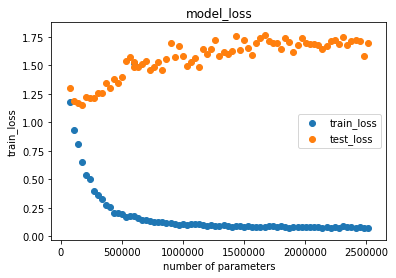

In [50]:
#plt.figure(figsize=(15, 8))
plt.scatter(parameters, train_loss, label="train_loss")
plt.scatter(parameters, test_loss, label="test_loss")
plt.xlabel('number of parameters')
plt.ylabel('train_loss')
plt.title('model_loss')
plt.legend(loc='best')
plt.show()

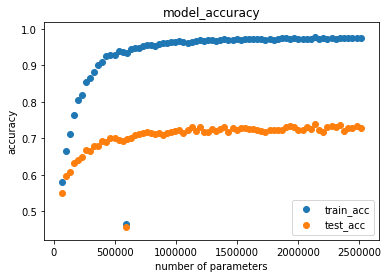

In [51]:
#plt.figure(figsize=(15, 8))
plt.scatter(parameters, train_acc, label="train_acc")
plt.scatter(parameters, test_acc, label="test_acc")
plt.xlabel('number of parameters')
plt.ylabel('accuracy')
plt.title('model_accuracy')
plt.legend(loc='best')
plt.show()